In [1]:
import numpy as np
import pandas as pd
import pandas as np
import matplotlib.pyplot as plt
import seaborn as sns
import klib

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import shap

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
data = pd.read_csv('서비스업_target수정.csv', encoding='cp949')
data = data.drop(columns = ['ID', 'SQ4'])

In [3]:
y = data['target']
X = data.drop(columns='target')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

model = CatBoostClassifier(random_state=42, verbose=False)
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, pred)

In [5]:
score

0.786669423766198

#### target과의 상관관계

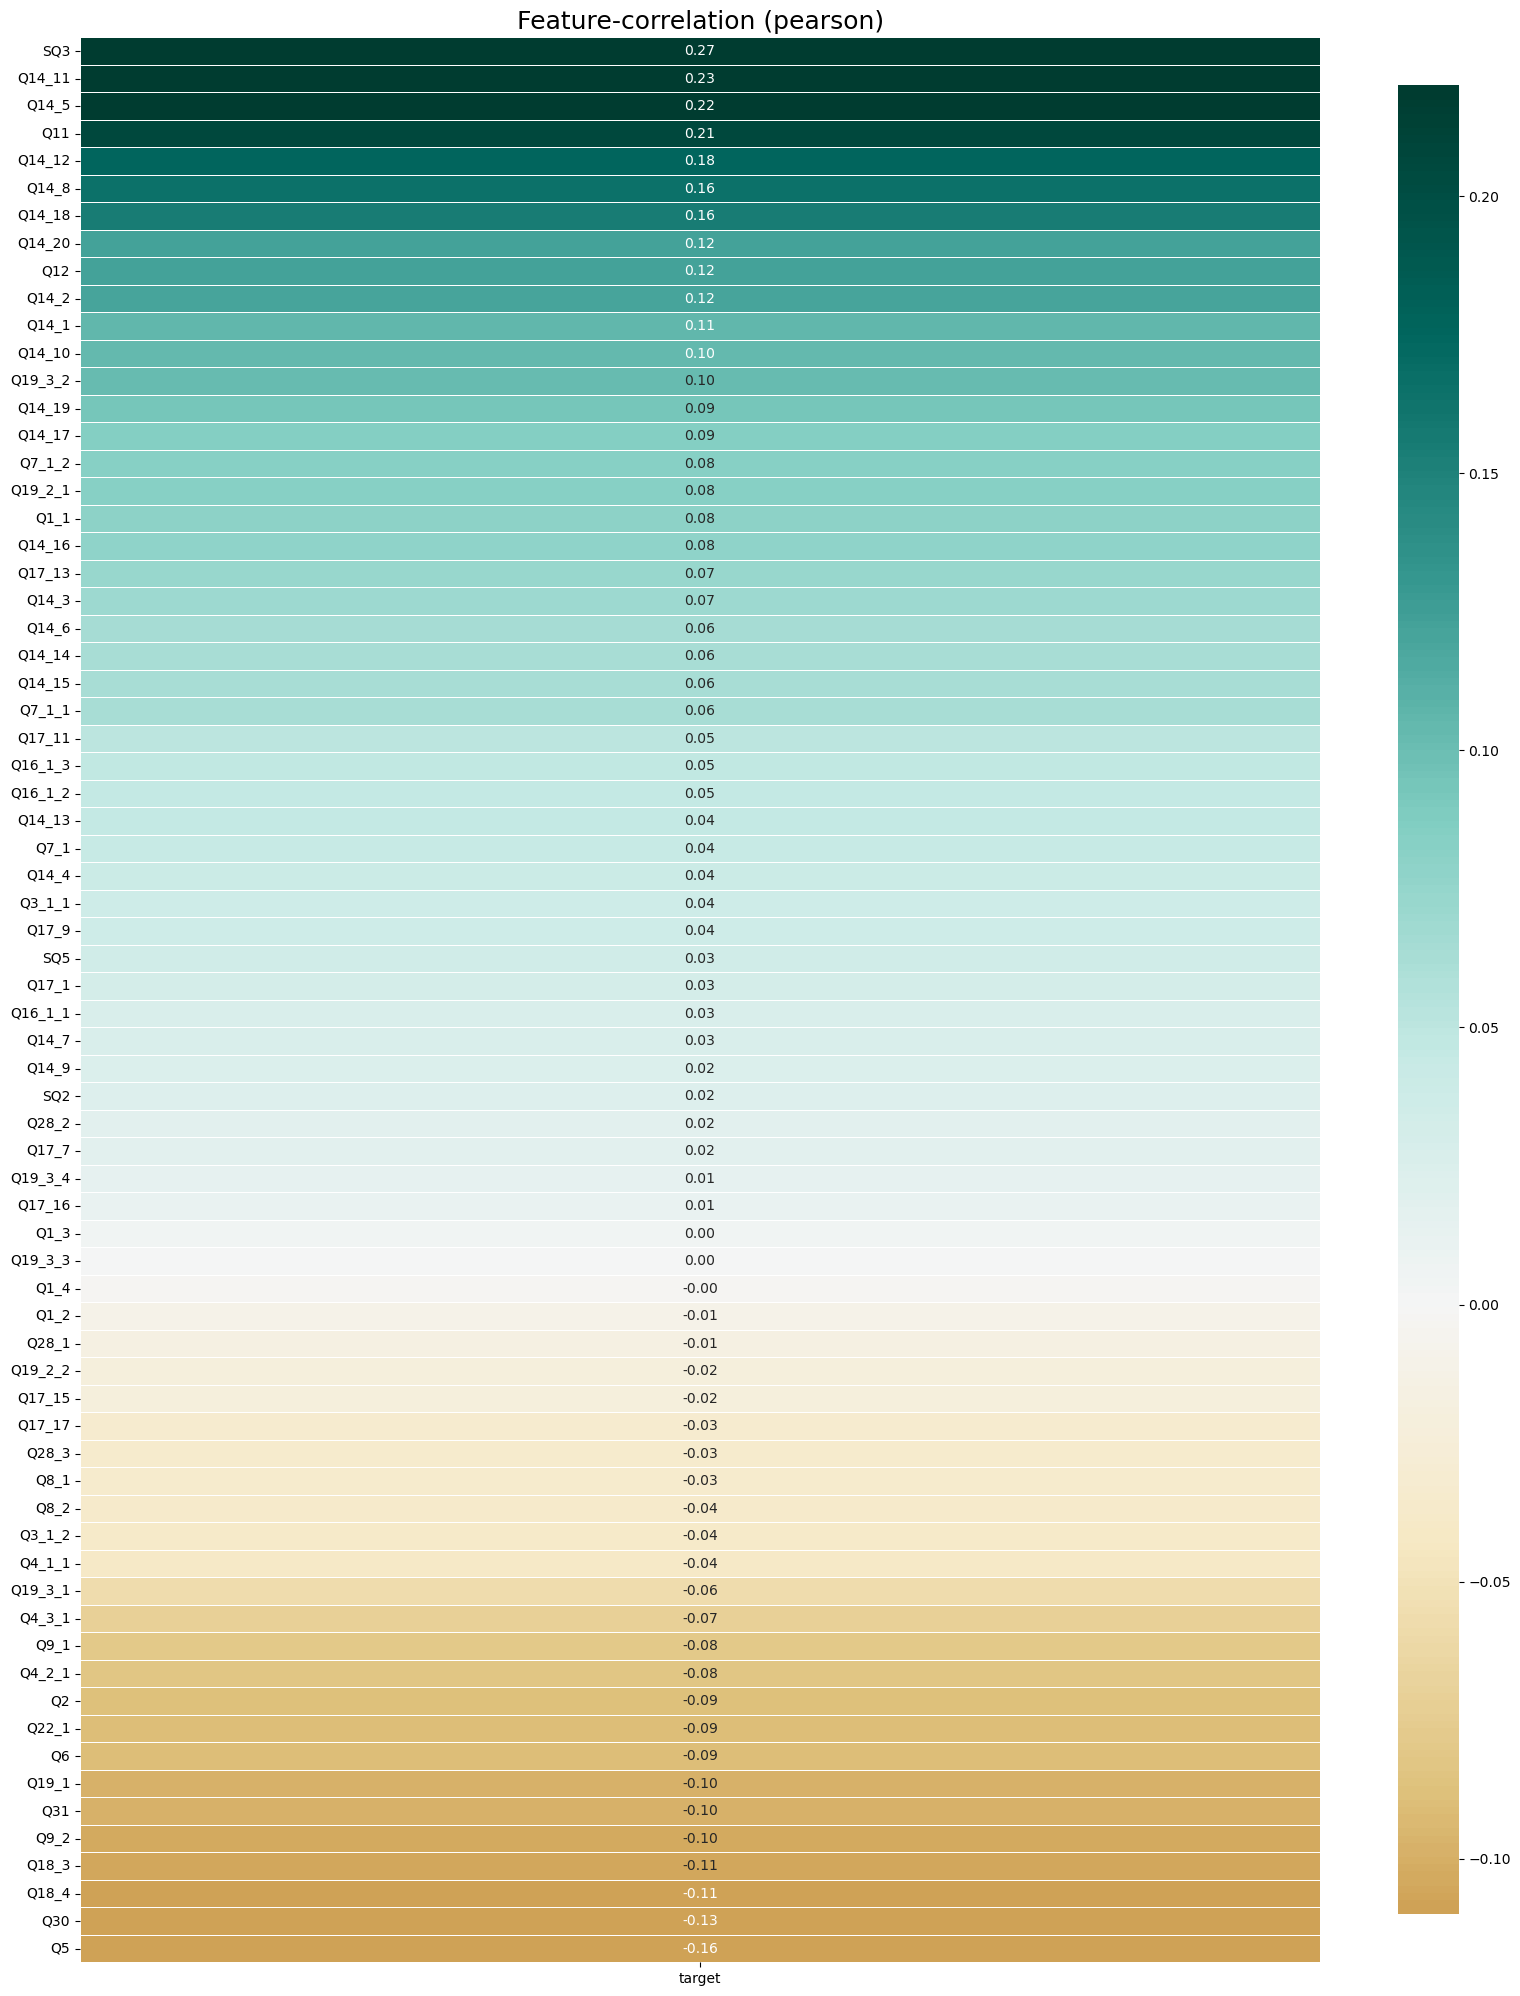

In [6]:
klib.corr_plot(data, target='target', figsize=(20, 25))
plt.show()

#### Feature Importance - SHAP

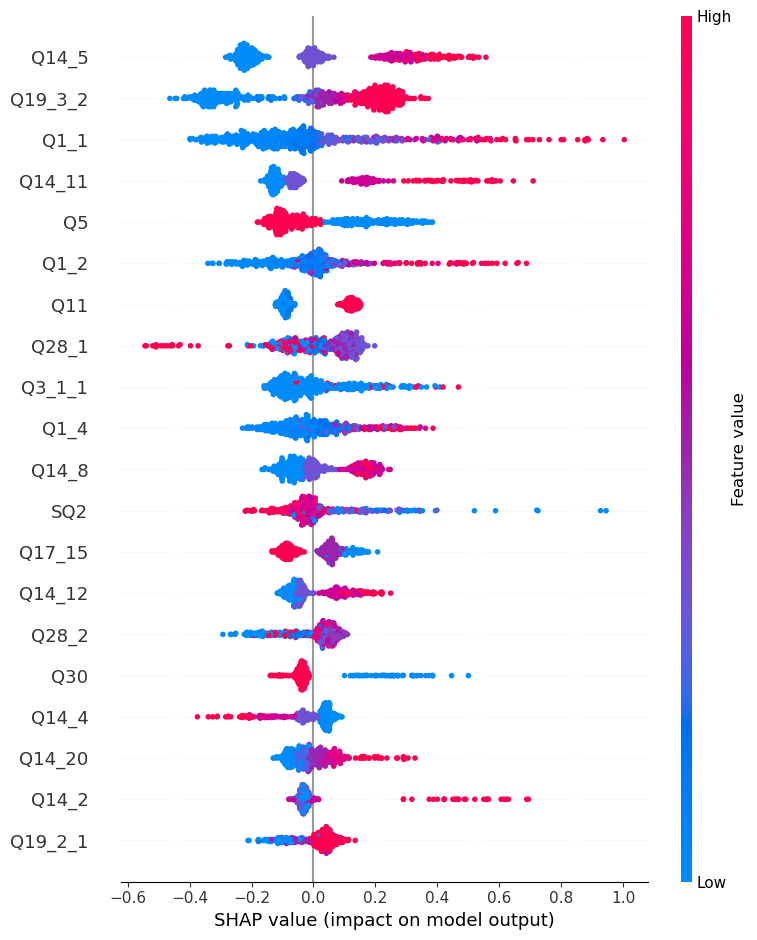

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

model = CatBoostClassifier(random_state=42, verbose=False)
model.fit(X_train, y_train)

# SHAP Explainer 생성
explainer = shap.TreeExplainer(model)

# SHAP 값 계산
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

#### Feature Importance - Model

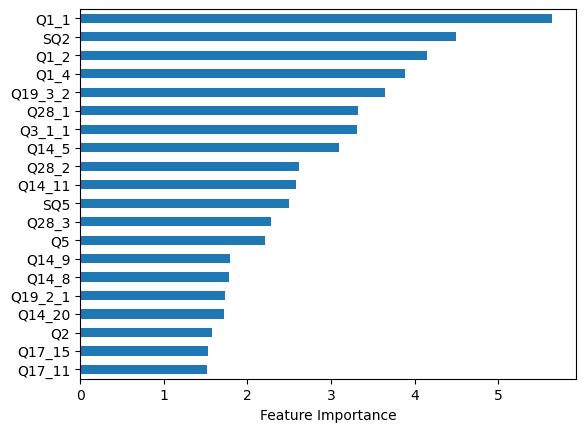

In [8]:
feature_import = pd.Series(model.feature_importances_, X.columns)
feature_import.sort_values(ascending=True).tail(20).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.show()

### <font color = 'navy'> Feature Engineering

In [3]:
data['underprivileged_ratio'] = (data['Q1_2'] * data['Q1_3'] * data['Q1_4']) / data['Q1_1']

data['Q14'] = data.loc[:, 'Q14_1':'Q14_20'].sum(axis=1)

data['supervise'] = data['Q7_1_1'] + data['Q8_1'] + data['Q8_2'] + data['Q12']

### <font color = 'navy'> Modeling

In [6]:
y = data['target']
X = data.drop(columns='target')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

#### CatBoost

In [39]:
def cat_objective(trial: Trial):
    params_cat = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_int('bagging_temperature', 0, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50)
    }
    
    model = CatBoostClassifier(**params_cat, random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', n_jobs = -1, cv=5)
    # score = np.mean(scores)
    score = sum(scores) / len(scores)
    
    return score

In [41]:
cat_study = optuna.create_study(sampler = optuna.samplers.TPESampler(seed=42), direction = 'maximize')
cat_study.optimize(cat_objective, n_trials = 200)

[I 2023-07-18 15:36:48,961] A new study created in memory with name: no-name-e455a571-1a05-421f-999d-7a349967672c
[I 2023-07-18 15:36:54,173] Trial 0 finished with value: 0.7429805186184012 and parameters: {'iterations': 250, 'depth': 10, 'learning_rate': 0.22227824312530747, 'random_strength': 60, 'bagging_temperature': 15, 'od_type': 'IncToDec', 'od_wait': 45}. Best is trial 0 with value: 0.7429805186184012.
[I 2023-07-18 15:36:56,248] Trial 1 finished with value: 0.7501668303204543 and parameters: {'iterations': 341, 'depth': 8, 'learning_rate': 0.01596950334578271, 'random_strength': 97, 'bagging_temperature': 84, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 1 with value: 0.7501668303204543.
[I 2023-07-18 15:36:57,710] Trial 2 finished with value: 0.7335998699222683 and parameters: {'iterations': 222, 'depth': 7, 'learning_rate': 0.13526405540621358, 'random_strength': 29, 'bagging_temperature': 61, 'od_type': 'Iter', 'od_wait': 25}. Best is trial 1 with value: 0.7501668303

[I 2023-07-18 15:37:23,448] Trial 28 finished with value: 0.7426800069121551 and parameters: {'iterations': 401, 'depth': 5, 'learning_rate': 0.06105912911139597, 'random_strength': 37, 'bagging_temperature': 91, 'od_type': 'IncToDec', 'od_wait': 46}. Best is trial 23 with value: 0.7516809674218259.
[I 2023-07-18 15:37:23,967] Trial 29 finished with value: 0.7375230569803232 and parameters: {'iterations': 256, 'depth': 6, 'learning_rate': 0.08864478508432208, 'random_strength': 60, 'bagging_temperature': 52, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial 23 with value: 0.7516809674218259.
[I 2023-07-18 15:37:24,396] Trial 30 finished with value: 0.7489958821432826 and parameters: {'iterations': 310, 'depth': 4, 'learning_rate': 0.03403539202307991, 'random_strength': 11, 'bagging_temperature': 92, 'od_type': 'IncToDec', 'od_wait': 49}. Best is trial 23 with value: 0.7516809674218259.
[I 2023-07-18 15:37:25,258] Trial 31 finished with value: 0.7430284465068087 and parameters: {'it

[I 2023-07-18 15:37:43,812] Trial 56 finished with value: 0.7422686279306259 and parameters: {'iterations': 400, 'depth': 6, 'learning_rate': 0.07215776257822992, 'random_strength': 55, 'bagging_temperature': 78, 'od_type': 'IncToDec', 'od_wait': 42}. Best is trial 35 with value: 0.753996386560146.
[I 2023-07-18 15:37:45,354] Trial 57 finished with value: 0.7476470046332433 and parameters: {'iterations': 430, 'depth': 8, 'learning_rate': 0.031190005429955557, 'random_strength': 44, 'bagging_temperature': 71, 'od_type': 'IncToDec', 'od_wait': 37}. Best is trial 35 with value: 0.753996386560146.
[I 2023-07-18 15:37:48,108] Trial 58 finished with value: 0.7458437260525299 and parameters: {'iterations': 223, 'depth': 10, 'learning_rate': 0.04621266060349913, 'random_strength': 29, 'bagging_temperature': 64, 'od_type': 'IncToDec', 'od_wait': 46}. Best is trial 35 with value: 0.753996386560146.
[I 2023-07-18 15:37:48,710] Trial 59 finished with value: 0.7436105091064277 and parameters: {'ite

[I 2023-07-18 15:38:06,659] Trial 84 finished with value: 0.7501799462111428 and parameters: {'iterations': 481, 'depth': 5, 'learning_rate': 0.036950979647150245, 'random_strength': 11, 'bagging_temperature': 57, 'od_type': 'IncToDec', 'od_wait': 45}. Best is trial 76 with value: 0.7568073877038505.
[I 2023-07-18 15:38:07,371] Trial 85 finished with value: 0.7427390751133399 and parameters: {'iterations': 435, 'depth': 5, 'learning_rate': 0.04892984732527469, 'random_strength': 7, 'bagging_temperature': 69, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial 76 with value: 0.7568073877038505.
[I 2023-07-18 15:38:08,025] Trial 86 finished with value: 0.7479578987774382 and parameters: {'iterations': 403, 'depth': 5, 'learning_rate': 0.05856148205926218, 'random_strength': 11, 'bagging_temperature': 43, 'od_type': 'Iter', 'od_wait': 49}. Best is trial 76 with value: 0.7568073877038505.
[I 2023-07-18 15:38:08,760] Trial 87 finished with value: 0.7487535560731224 and parameters: {'iterat

[I 2023-07-18 15:38:30,004] Trial 112 finished with value: 0.7510000233333902 and parameters: {'iterations': 371, 'depth': 5, 'learning_rate': 0.030691130397873786, 'random_strength': 27, 'bagging_temperature': 77, 'od_type': 'Iter', 'od_wait': 49}. Best is trial 102 with value: 0.7576551208123765.
[I 2023-07-18 15:38:30,671] Trial 113 finished with value: 0.7517205079166089 and parameters: {'iterations': 411, 'depth': 5, 'learning_rate': 0.037606299735451, 'random_strength': 15, 'bagging_temperature': 85, 'od_type': 'Iter', 'od_wait': 50}. Best is trial 102 with value: 0.7576551208123765.
[I 2023-07-18 15:38:31,329] Trial 114 finished with value: 0.7513603279701347 and parameters: {'iterations': 403, 'depth': 5, 'learning_rate': 0.022855155986446947, 'random_strength': 17, 'bagging_temperature': 30, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 102 with value: 0.7576551208123765.
[I 2023-07-18 15:38:31,949] Trial 115 finished with value: 0.7557522983586684 and parameters: {'iterati

[I 2023-07-18 15:38:49,011] Trial 140 finished with value: 0.7486548752988129 and parameters: {'iterations': 415, 'depth': 5, 'learning_rate': 0.04514020319080814, 'random_strength': 16, 'bagging_temperature': 16, 'od_type': 'Iter', 'od_wait': 44}. Best is trial 102 with value: 0.7576551208123765.
[I 2023-07-18 15:38:49,658] Trial 141 finished with value: 0.7489451487237938 and parameters: {'iterations': 386, 'depth': 5, 'learning_rate': 0.036578714934280755, 'random_strength': 10, 'bagging_temperature': 81, 'od_type': 'Iter', 'od_wait': 21}. Best is trial 102 with value: 0.7576551208123765.
[I 2023-07-18 15:38:50,312] Trial 142 finished with value: 0.750493195791372 and parameters: {'iterations': 398, 'depth': 5, 'learning_rate': 0.03796005126752642, 'random_strength': 13, 'bagging_temperature': 74, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 102 with value: 0.7576551208123765.
[I 2023-07-18 15:38:50,954] Trial 143 finished with value: 0.7515467985865174 and parameters: {'iterati

[I 2023-07-18 15:39:07,434] Trial 168 finished with value: 0.7516039438217195 and parameters: {'iterations': 371, 'depth': 5, 'learning_rate': 0.031108798350654, 'random_strength': 12, 'bagging_temperature': 75, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial 102 with value: 0.7576551208123765.
[I 2023-07-18 15:39:08,033] Trial 169 finished with value: 0.7468431898580616 and parameters: {'iterations': 356, 'depth': 5, 'learning_rate': 0.015262723176689492, 'random_strength': 6, 'bagging_temperature': 83, 'od_type': 'IncToDec', 'od_wait': 45}. Best is trial 102 with value: 0.7576551208123765.
[I 2023-07-18 15:39:08,660] Trial 170 finished with value: 0.7471773718831806 and parameters: {'iterations': 379, 'depth': 5, 'learning_rate': 0.048287244158025204, 'random_strength': 10, 'bagging_temperature': 80, 'od_type': 'IncToDec', 'od_wait': 46}. Best is trial 102 with value: 0.7576551208123765.
[I 2023-07-18 15:39:09,289] Trial 171 finished with value: 0.7566309254546059 and parameters

[I 2023-07-18 15:39:25,454] Trial 196 finished with value: 0.7483079359332973 and parameters: {'iterations': 361, 'depth': 5, 'learning_rate': 0.05327423654902444, 'random_strength': 21, 'bagging_temperature': 69, 'od_type': 'Iter', 'od_wait': 49}. Best is trial 102 with value: 0.7576551208123765.
[I 2023-07-18 15:39:26,092] Trial 197 finished with value: 0.7536357175857975 and parameters: {'iterations': 387, 'depth': 5, 'learning_rate': 0.03257036474331691, 'random_strength': 14, 'bagging_temperature': 84, 'od_type': 'Iter', 'od_wait': 46}. Best is trial 102 with value: 0.7576551208123765.
[I 2023-07-18 15:39:26,711] Trial 198 finished with value: 0.7463846311297467 and parameters: {'iterations': 379, 'depth': 5, 'learning_rate': 0.016905277597987503, 'random_strength': 24, 'bagging_temperature': 46, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial 102 with value: 0.7576551208123765.
[I 2023-07-18 15:39:27,439] Trial 199 finished with value: 0.750778054922802 and parameters: {'ite

In [45]:
CAT = CatBoostClassifier(**cat_study.best_params, random_state=42, verbose=False)
CAT.fit(X_train, y_train)
cat_pred = CAT.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, cat_pred)

In [46]:
score

0.7935851484238581

#### LGBM

In [24]:
def lgb_objective(trial: Trial):
    
    params_lgb = {
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000) ,
        'max_depth': trial.suggest_int('max_depth', 6, 20), 
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1), 
        'n_estimators': trial.suggest_int('n_estimators', 1500, 3000, step=1), 
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100), 
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
    }
    
    model = LGBMClassifier(random_state=42, **params_lgb)
    scores = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', n_jobs = -1, cv=5)
    # score = np.mean(scores)
    score = sum(scores) / len(scores)
    
    return score

In [25]:
lgb_study = optuna.create_study(sampler = optuna.samplers.TPESampler(seed=42), direction = 'maximize')
lgb_study.optimize(lgb_objective, n_trials = 100)

[I 2023-07-18 14:50:11,042] A new study created in memory with name: no-name-6a9d8ab2-9ffb-4496-be25-db6a3e1db549
[I 2023-07-18 14:50:13,396] Trial 0 finished with value: 0.7385059993250415 and parameters: {'num_leaves': 381, 'max_depth': 20, 'learning_rate': 0.07322619478695937, 'n_estimators': 2398, 'class_weight': 'balanced', 'min_child_samples': 15, 'subsample': 0.9598528437324805, 'colsample_bytree': 0.8803345035229626, 'reg_alpha': 0.7080725777960455, 'reg_lambda': 0.020584494295802447}. Best is trial 0 with value: 0.7385059993250415.
[I 2023-07-18 14:50:15,198] Trial 1 finished with value: 0.7262508547794241 and parameters: {'num_leaves': 971, 'max_depth': 18, 'learning_rate': 0.021312677156759788, 'n_estimators': 1772, 'class_weight': None, 'min_child_samples': 57, 'subsample': 0.8295835055926347, 'colsample_bytree': 0.7873687420594125, 'reg_alpha': 0.6118528947223795, 'reg_lambda': 0.13949386065204183}. Best is trial 0 with value: 0.7385059993250415.
[I 2023-07-18 14:50:16,822

[I 2023-07-18 14:50:32,092] Trial 19 finished with value: 0.7208055017766652 and parameters: {'num_leaves': 820, 'max_depth': 8, 'learning_rate': 0.048640364740230924, 'n_estimators': 2179, 'class_weight': 'balanced', 'min_child_samples': 39, 'subsample': 0.9664658569537325, 'colsample_bytree': 0.9619427285565617, 'reg_alpha': 0.6151457448131913, 'reg_lambda': 0.34593944407205146}. Best is trial 11 with value: 0.7408267567326761.
[I 2023-07-18 14:50:32,511] Trial 20 finished with value: 0.7354360414806123 and parameters: {'num_leaves': 461, 'max_depth': 16, 'learning_rate': 0.08411333040608958, 'n_estimators': 1883, 'class_weight': 'balanced', 'min_child_samples': 10, 'subsample': 0.9154166093935949, 'colsample_bytree': 0.9015886328051116, 'reg_alpha': 0.6587897744017712, 'reg_lambda': 0.2119445753610314}. Best is trial 11 with value: 0.7408267567326761.
[I 2023-07-18 14:50:32,990] Trial 21 finished with value: 0.7290143449842537 and parameters: {'num_leaves': 366, 'max_depth': 20, 'le

[I 2023-07-18 14:50:50,230] Trial 38 finished with value: 0.7450663066818228 and parameters: {'num_leaves': 988, 'max_depth': 14, 'learning_rate': 0.0007871688505821138, 'n_estimators': 2656, 'class_weight': None, 'min_child_samples': 58, 'subsample': 0.8696549939676145, 'colsample_bytree': 0.8286185708978187, 'reg_alpha': 0.5006431437113025, 'reg_lambda': 0.11871631937486521}. Best is trial 37 with value: 0.7467318959000393.
[I 2023-07-18 14:50:51,638] Trial 39 finished with value: 0.7380368145655491 and parameters: {'num_leaves': 992, 'max_depth': 14, 'learning_rate': 0.0005456441204521533, 'n_estimators': 2672, 'class_weight': None, 'min_child_samples': 61, 'subsample': 0.8649350643718944, 'colsample_bytree': 0.8350190191446646, 'reg_alpha': 0.48294822846783086, 'reg_lambda': 0.09661510969349169}. Best is trial 37 with value: 0.7467318959000393.
[I 2023-07-18 14:50:52,959] Trial 40 finished with value: 0.7247909950370379 and parameters: {'num_leaves': 923, 'max_depth': 13, 'learning

[I 2023-07-18 14:51:17,988] Trial 58 finished with value: 0.7305571550604796 and parameters: {'num_leaves': 687, 'max_depth': 10, 'learning_rate': 0.010750100035685883, 'n_estimators': 2779, 'class_weight': None, 'min_child_samples': 41, 'subsample': 0.8938335275520733, 'colsample_bytree': 0.8617813309257782, 'reg_alpha': 0.524219101854664, 'reg_lambda': 0.14437992595852378}. Best is trial 42 with value: 0.7470460280453672.
[I 2023-07-18 14:51:20,125] Trial 59 finished with value: 0.7381266754761834 and parameters: {'num_leaves': 949, 'max_depth': 17, 'learning_rate': 0.004945688157803297, 'n_estimators': 2942, 'class_weight': None, 'min_child_samples': 35, 'subsample': 0.9381689273542098, 'colsample_bytree': 0.8732593926817985, 'reg_alpha': 0.5764171410753786, 'reg_lambda': 0.08517135239652487}. Best is trial 42 with value: 0.7470460280453672.
[I 2023-07-18 14:51:21,629] Trial 60 finished with value: 0.7401808837557067 and parameters: {'num_leaves': 770, 'max_depth': 15, 'learning_rat

[I 2023-07-18 14:51:50,653] Trial 78 finished with value: 0.7280756755772773 and parameters: {'num_leaves': 934, 'max_depth': 18, 'learning_rate': 0.017549034938421307, 'n_estimators': 2695, 'class_weight': None, 'min_child_samples': 47, 'subsample': 0.9525692306977257, 'colsample_bytree': 0.8994744149266065, 'reg_alpha': 0.5685622392543981, 'reg_lambda': 0.20818042314367186}. Best is trial 42 with value: 0.7470460280453672.
[I 2023-07-18 14:51:52,616] Trial 79 finished with value: 0.7387102480381473 and parameters: {'num_leaves': 235, 'max_depth': 15, 'learning_rate': 0.0048207130174904664, 'n_estimators': 2888, 'class_weight': None, 'min_child_samples': 30, 'subsample': 0.8740036600432531, 'colsample_bytree': 0.890289733826847, 'reg_alpha': 0.468361725967946, 'reg_lambda': 0.0306631034700188}. Best is trial 42 with value: 0.7470460280453672.
[I 2023-07-18 14:51:53,961] Trial 80 finished with value: 0.730611336928815 and parameters: {'num_leaves': 456, 'max_depth': 16, 'learning_rate'

[I 2023-07-18 14:52:20,861] Trial 98 finished with value: 0.7274820128366265 and parameters: {'num_leaves': 976, 'max_depth': 6, 'learning_rate': 0.013583899124940266, 'n_estimators': 1821, 'class_weight': None, 'min_child_samples': 41, 'subsample': 0.8997100146612799, 'colsample_bytree': 0.8556571869970402, 'reg_alpha': 0.5833891277027958, 'reg_lambda': 0.18358189751708734}. Best is trial 87 with value: 0.7477075535971526.
[I 2023-07-18 14:52:22,017] Trial 99 finished with value: 0.7296081226819677 and parameters: {'num_leaves': 307, 'max_depth': 8, 'learning_rate': 0.010850182525634706, 'n_estimators': 2012, 'class_weight': None, 'min_child_samples': 33, 'subsample': 0.8909370962234849, 'colsample_bytree': 0.8669098793198021, 'reg_alpha': 0.4952317014275219, 'reg_lambda': 0.10292889842399736}. Best is trial 87 with value: 0.7477075535971526.


In [26]:
LGBM = LGBMClassifier(**lgb_study.best_params, random_state=42)
LGBM.fit(X_train, y_train)
lgbm_pred = LGBM.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, lgbm_pred)

In [28]:
score

0.7843488649940262

#### RandomForest

In [89]:
def rf_objective(trial: Trial):
    
    params_rf = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 500),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'n_estimators':  trial.suggest_int('n_estimators', 100, 1000)
            }
    
    model = RandomForestClassifier(random_state=42, **params_rf)
    scores = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', n_jobs = -1, cv=5)
    # score = np.mean(scores)
    score = sum(scores) / len(scores)
    
    return score

In [90]:
rf_study = optuna.create_study(sampler = optuna.samplers.TPESampler(seed=42), direction = 'maximize')
rf_study.optimize(rf_objective, n_trials = 100)

[I 2023-07-18 15:45:22,989] A new study created in memory with name: no-name-50b2b37b-65a5-4ca9-becf-4bdee41678e2
[I 2023-07-18 15:45:25,309] Trial 0 finished with value: 0.747977695330794 and parameters: {'max_depth': 9, 'max_leaf_nodes': 476, 'min_samples_leaf': 15, 'n_estimators': 639}. Best is trial 0 with value: 0.747977695330794.
[I 2023-07-18 15:45:26,868] Trial 1 finished with value: 0.746464680441855 and parameters: {'max_depth': 5, 'max_leaf_nodes': 79, 'min_samples_leaf': 2, 'n_estimators': 880}. Best is trial 0 with value: 0.747977695330794.
[I 2023-07-18 15:45:29,301] Trial 2 finished with value: 0.7541197696870745 and parameters: {'max_depth': 13, 'max_leaf_nodes': 355, 'min_samples_leaf': 1, 'n_estimators': 973}. Best is trial 2 with value: 0.7541197696870745.
[I 2023-07-18 15:45:30,255] Trial 3 finished with value: 0.7520596054741974 and parameters: {'max_depth': 17, 'max_leaf_nodes': 107, 'min_samples_leaf': 4, 'n_estimators': 265}. Best is trial 2 with value: 0.754119

[I 2023-07-18 15:46:05,916] Trial 36 finished with value: 0.7532752493259556 and parameters: {'max_depth': 15, 'max_leaf_nodes': 43, 'min_samples_leaf': 3, 'n_estimators': 937}. Best is trial 28 with value: 0.7567795096952341.
[I 2023-07-18 15:46:07,032] Trial 37 finished with value: 0.7495361540359412 and parameters: {'max_depth': 6, 'max_leaf_nodes': 62, 'min_samples_leaf': 4, 'n_estimators': 862}. Best is trial 28 with value: 0.7567795096952341.
[I 2023-07-18 15:46:08,363] Trial 38 finished with value: 0.755142229114268 and parameters: {'max_depth': 13, 'max_leaf_nodes': 108, 'min_samples_leaf': 2, 'n_estimators': 772}. Best is trial 28 with value: 0.7567795096952341.
[I 2023-07-18 15:46:09,703] Trial 39 finished with value: 0.7535237475644951 and parameters: {'max_depth': 10, 'max_leaf_nodes': 80, 'min_samples_leaf': 5, 'n_estimators': 856}. Best is trial 28 with value: 0.7567795096952341.
[I 2023-07-18 15:46:10,633] Trial 40 finished with value: 0.7502516704747618 and parameters: 

[I 2023-07-18 15:46:52,732] Trial 72 finished with value: 0.7555559577445192 and parameters: {'max_depth': 19, 'max_leaf_nodes': 409, 'min_samples_leaf': 2, 'n_estimators': 647}. Best is trial 28 with value: 0.7567795096952341.
[I 2023-07-18 15:46:53,737] Trial 73 finished with value: 0.7523174360165952 and parameters: {'max_depth': 7, 'max_leaf_nodes': 469, 'min_samples_leaf': 3, 'n_estimators': 690}. Best is trial 28 with value: 0.7567795096952341.
[I 2023-07-18 15:46:55,144] Trial 74 finished with value: 0.7553457004861317 and parameters: {'max_depth': 18, 'max_leaf_nodes': 430, 'min_samples_leaf': 2, 'n_estimators': 726}. Best is trial 28 with value: 0.7567795096952341.
[I 2023-07-18 15:46:56,720] Trial 75 finished with value: 0.7572786064404945 and parameters: {'max_depth': 16, 'max_leaf_nodes': 479, 'min_samples_leaf': 2, 'n_estimators': 824}. Best is trial 75 with value: 0.7572786064404945.
[I 2023-07-18 15:46:58,433] Trial 76 finished with value: 0.7529752217809806 and paramete

In [91]:
RF = RandomForestClassifier(**rf_study.best_params, random_state=42)
RF.fit(X_train, y_train)
rf_pred = RF.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, rf_pred)

In [92]:
score

0.7893805716386362

#### ExtraTrees

In [29]:
def et_objective(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 10, 200),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42
    }
        
    model = ExtraTreesClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', n_jobs = -1, cv=5) ## 평가지표 변경 필요
    # score = np.mean(scores)
    score = sum(scores) / len(scores)
    
    return score

In [30]:
et_study = optuna.create_study(sampler = optuna.samplers.TPESampler(seed=42), direction = 'maximize')
et_study.optimize(et_objective, n_trials = 200)

[I 2023-07-18 14:58:36,816] A new study created in memory with name: no-name-619d475a-ca76-4b2d-b851-fbf5c43b4a2e
[I 2023-07-18 14:58:38,445] Trial 0 finished with value: 0.7577715281237194 and parameters: {'n_estimators': 81, 'criterion': 'gini', 'max_depth': 124, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.7577715281237194.
[I 2023-07-18 14:58:39,091] Trial 1 finished with value: 0.7570284443497196 and parameters: {'n_estimators': 124, 'criterion': 'gini', 'max_depth': 195, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.7577715281237194.
[I 2023-07-18 14:58:39,681] Trial 2 finished with value: 0.7411964228728991 and parameters: {'n_estimators': 68, 'criterion': 'gini', 'max_depth': 65, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.7577715281237194.
[I 2023-07-18 14:58:40,330] Trial 3 finished with value: 0.75660575459

[I 2023-07-18 14:58:44,849] Trial 30 finished with value: 0.7564635890074005 and parameters: {'n_estimators': 160, 'criterion': 'gini', 'max_depth': 58, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.7590573210379606.
[I 2023-07-18 14:58:45,011] Trial 31 finished with value: 0.757016584174232 and parameters: {'n_estimators': 92, 'criterion': 'gini', 'max_depth': 86, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.7590573210379606.
[I 2023-07-18 14:58:45,150] Trial 32 finished with value: 0.7531052300649919 and parameters: {'n_estimators': 75, 'criterion': 'gini', 'max_depth': 110, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.7590573210379606.
[I 2023-07-18 14:58:45,337] Trial 33 finished with value: 0.7520629166059108 and parameters: {'n_estimators': 113, 'criterion': 'gini', 'max_depth': 79, 'min_samples_split': 7, 'mi

[I 2023-07-18 14:58:49,690] Trial 60 finished with value: 0.7500037859543671 and parameters: {'n_estimators': 109, 'criterion': 'gini', 'max_depth': 140, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.7590573210379606.
[I 2023-07-18 14:58:49,919] Trial 61 finished with value: 0.7550987511427639 and parameters: {'n_estimators': 147, 'criterion': 'gini', 'max_depth': 107, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 23 with value: 0.7590573210379606.
[I 2023-07-18 14:58:50,080] Trial 62 finished with value: 0.7564277746209159 and parameters: {'n_estimators': 98, 'criterion': 'gini', 'max_depth': 170, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 23 with value: 0.7590573210379606.
[I 2023-07-18 14:58:50,276] Trial 63 finished with value: 0.753733376504928 and parameters: {'n_estimators': 119, 'criterion': 'gini', 'max_depth': 91, 'min_samples_split': 4, 

[I 2023-07-18 14:58:58,177] Trial 90 finished with value: 0.7627548905220742 and parameters: {'n_estimators': 187, 'criterion': 'entropy', 'max_depth': 124, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 78 with value: 0.7643788535771363.
[I 2023-07-18 14:58:58,504] Trial 91 finished with value: 0.7630555824241749 and parameters: {'n_estimators': 185, 'criterion': 'entropy', 'max_depth': 125, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 78 with value: 0.7643788535771363.
[I 2023-07-18 14:58:58,834] Trial 92 finished with value: 0.7627548905220742 and parameters: {'n_estimators': 187, 'criterion': 'entropy', 'max_depth': 122, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 78 with value: 0.7643788535771363.
[I 2023-07-18 14:58:59,162] Trial 93 finished with value: 0.7627548905220742 and parameters: {'n_estimators': 187, 'criterion': 'entropy', 'max_depth': 122, 'min_samp

[I 2023-07-18 14:59:07,021] Trial 120 finished with value: 0.7583161066973065 and parameters: {'n_estimators': 167, 'criterion': 'entropy', 'max_depth': 176, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 109 with value: 0.7659684459170288.
[I 2023-07-18 14:59:07,286] Trial 121 finished with value: 0.7646830270735985 and parameters: {'n_estimators': 145, 'criterion': 'entropy', 'max_depth': 147, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 109 with value: 0.7659684459170288.
[I 2023-07-18 14:59:07,549] Trial 122 finished with value: 0.7632978675885609 and parameters: {'n_estimators': 142, 'criterion': 'entropy', 'max_depth': 149, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 109 with value: 0.7659684459170288.
[I 2023-07-18 14:59:07,825] Trial 123 finished with value: 0.7657503117322522 and parameters: {'n_estimators': 151, 'criterion': 'entropy', 'max_depth': 147, 'm

[I 2023-07-18 14:59:15,066] Trial 150 finished with value: 0.7632978675885609 and parameters: {'n_estimators': 142, 'criterion': 'entropy', 'max_depth': 181, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 131 with value: 0.7659784377114095.
[I 2023-07-18 14:59:15,341] Trial 151 finished with value: 0.7659666379081097 and parameters: {'n_estimators': 153, 'criterion': 'entropy', 'max_depth': 164, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 131 with value: 0.7659784377114095.
[I 2023-07-18 14:59:15,608] Trial 152 finished with value: 0.7650317549816197 and parameters: {'n_estimators': 148, 'criterion': 'entropy', 'max_depth': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 131 with value: 0.7659784377114095.
[I 2023-07-18 14:59:15,883] Trial 153 finished with value: 0.7659666379081097 and parameters: {'n_estimators': 153, 'criterion': 'entropy', 'max_depth': 164, 'm

[I 2023-07-18 14:59:23,096] Trial 180 finished with value: 0.7621698168102634 and parameters: {'n_estimators': 138, 'criterion': 'entropy', 'max_depth': 190, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 131 with value: 0.7659784377114095.
[I 2023-07-18 14:59:23,373] Trial 181 finished with value: 0.7659590103622612 and parameters: {'n_estimators': 152, 'criterion': 'entropy', 'max_depth': 162, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 131 with value: 0.7659784377114095.
[I 2023-07-18 14:59:23,656] Trial 182 finished with value: 0.7659784377114095 and parameters: {'n_estimators': 157, 'criterion': 'entropy', 'max_depth': 166, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 131 with value: 0.7659784377114095.
[I 2023-07-18 14:59:23,939] Trial 183 finished with value: 0.7654733129544536 and parameters: {'n_estimators': 159, 'criterion': 'entropy', 'max_depth': 166, 'm

In [33]:
ET = ExtraTreesClassifier(**et_study.best_params)
ET.fit(X_train, y_train)
et_pred = ET.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, et_pred)

In [34]:
score

0.7745037220843672

#### XGBoost

In [35]:
def xgb_objective(trial: Trial):
    
    params_xgb = {
        "max_depth": trial.suggest_int("max_depth", 6, 16),
        "learning_rate": trial.suggest_float('learning_rate', 0.05, 0.99),
        'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, step=100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 1, log= True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 1, log= True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step = 0.05),     
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
        "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
    }
    
    model = XGBClassifier(random_state=42, **params_xgb)
    scores = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', n_jobs = -1, cv=11) ## 평가지표 변경 필요
    # score = np.mean(scores)
    score = sum(scores) / len(scores)
    
    return score

In [36]:
xgb_study = optuna.create_study(sampler = optuna.samplers.TPESampler(seed=42), direction = 'maximize')
xgb_study.optimize(xgb_objective, n_trials = 200)

[I 2023-07-18 15:01:58,610] A new study created in memory with name: no-name-67fdda9a-4b0a-4e0e-b573-480fb9eef21a
[I 2023-07-18 15:02:04,809] Trial 0 finished with value: 0.6869851175134932 and parameters: {'max_depth': 10, 'learning_rate': 0.9436714480253212, 'n_estimators': 7600, 'colsample_bytree': 0.7993292420985183, 'colsample_bylevel': 0.5780093202212182, 'colsample_bynode': 0.5779972601681014, 'reg_lambda': 0.01306673923805328, 'reg_alpha': 0.5399484409787431, 'subsample': 0.85, 'min_child_weight': 11, 'gamma': 0.10485387725194621}. Best is trial 0 with value: 0.6869851175134932.
[I 2023-07-18 15:02:07,235] Trial 1 finished with value: 0.6707845318412833 and parameters: {'max_depth': 16, 'learning_rate': 0.8324960823523965, 'n_estimators': 2900, 'colsample_bytree': 0.5909124836035503, 'colsample_bylevel': 0.5917022549267169, 'colsample_bynode': 0.6521211214797689, 'reg_lambda': 0.11207606211860566, 'reg_alpha': 0.0730953983591291, 'subsample': 0.7, 'min_child_weight': 10, 'gamma

[I 2023-07-18 15:03:57,953] Trial 17 finished with value: 0.7222994444129474 and parameters: {'max_depth': 11, 'learning_rate': 0.1540800081988835, 'n_estimators': 6400, 'colsample_bytree': 0.508832228335537, 'colsample_bylevel': 0.7188556446135832, 'colsample_bynode': 0.8587625115483171, 'reg_lambda': 0.023422224392507716, 'reg_alpha': 0.13957044245611344, 'subsample': 0.95, 'min_child_weight': 3, 'gamma': 0.16002321310625298}. Best is trial 11 with value: 0.7326863178135194.
[I 2023-07-18 15:04:09,073] Trial 18 finished with value: 0.7172395988442954 and parameters: {'max_depth': 12, 'learning_rate': 0.09075567016795699, 'n_estimators': 8200, 'colsample_bytree': 0.6933145661944939, 'colsample_bylevel': 0.6558023827556908, 'colsample_bynode': 0.933703415650462, 'reg_lambda': 0.050709525971449884, 'reg_alpha': 0.28686849471064807, 'subsample': 0.9, 'min_child_weight': 9, 'gamma': 0.23855952570950445}. Best is trial 11 with value: 0.7326863178135194.
[I 2023-07-18 15:04:14,976] Trial 19

[I 2023-07-18 15:08:06,070] Trial 35 finished with value: 0.7279134216511907 and parameters: {'max_depth': 10, 'learning_rate': 0.19716173126742442, 'n_estimators': 8600, 'colsample_bytree': 0.6356980201956819, 'colsample_bylevel': 0.7598978875269057, 'colsample_bynode': 0.9236523697237238, 'reg_lambda': 0.04503697411526931, 'reg_alpha': 0.45384004119665755, 'subsample': 0.95, 'min_child_weight': 4, 'gamma': 0.16234807503642626}. Best is trial 26 with value: 0.7446910558456546.
[I 2023-07-18 15:08:18,161] Trial 36 finished with value: 0.7273503839061568 and parameters: {'max_depth': 13, 'learning_rate': 0.052016201990880945, 'n_estimators': 7600, 'colsample_bytree': 0.604634555392366, 'colsample_bylevel': 0.786908537754488, 'colsample_bynode': 0.8800048004079831, 'reg_lambda': 0.01679206652643012, 'reg_alpha': 0.37730881109026315, 'subsample': 0.8, 'min_child_weight': 6, 'gamma': 0.2506101743955317}. Best is trial 26 with value: 0.7446910558456546.
[I 2023-07-18 15:08:35,451] Trial 37 

[I 2023-07-18 15:11:51,125] Trial 53 finished with value: 0.7412736209213705 and parameters: {'max_depth': 12, 'learning_rate': 0.05137432520432679, 'n_estimators': 9700, 'colsample_bytree': 0.6476512217148949, 'colsample_bylevel': 0.7481791020792589, 'colsample_bynode': 0.9879212290952837, 'reg_lambda': 0.014469591189305258, 'reg_alpha': 0.6304576424228765, 'subsample': 1.0, 'min_child_weight': 2, 'gamma': 0.136314176975617}. Best is trial 26 with value: 0.7446910558456546.
[I 2023-07-18 15:11:57,884] Trial 54 finished with value: 0.7466078170579149 and parameters: {'max_depth': 12, 'learning_rate': 0.09513890638071898, 'n_estimators': 10000, 'colsample_bytree': 0.6510550485160946, 'colsample_bylevel': 0.7396886133843736, 'colsample_bynode': 0.9881677869351018, 'reg_lambda': 0.012225914777274433, 'reg_alpha': 0.6526875939961406, 'subsample': 1.0, 'min_child_weight': 2, 'gamma': 0.11365693061828626}. Best is trial 54 with value: 0.7466078170579149.
[I 2023-07-18 15:12:05,745] Trial 55 

[I 2023-07-18 15:14:56,841] Trial 71 finished with value: 0.736501593644451 and parameters: {'max_depth': 12, 'learning_rate': 0.11049962589538077, 'n_estimators': 9500, 'colsample_bytree': 0.6482616805146414, 'colsample_bylevel': 0.7572267318077524, 'colsample_bynode': 0.995058527748022, 'reg_lambda': 0.019169115793838842, 'reg_alpha': 0.659053098957889, 'subsample': 0.95, 'min_child_weight': 3, 'gamma': 0.13348116963893}. Best is trial 54 with value: 0.7466078170579149.
[I 2023-07-18 15:15:11,943] Trial 72 finished with value: 0.7350242712277937 and parameters: {'max_depth': 11, 'learning_rate': 0.10946358366252396, 'n_estimators': 8400, 'colsample_bytree': 0.6498287928134847, 'colsample_bylevel': 0.791520845782626, 'colsample_bynode': 0.9703407805051965, 'reg_lambda': 0.015144633662350825, 'reg_alpha': 0.5693557763475523, 'subsample': 0.95, 'min_child_weight': 3, 'gamma': 0.12021416297010538}. Best is trial 54 with value: 0.7466078170579149.
[I 2023-07-18 15:15:31,627] Trial 73 fini

[I 2023-07-18 15:18:21,260] Trial 89 finished with value: 0.7360013328702174 and parameters: {'max_depth': 15, 'learning_rate': 0.0875292285694852, 'n_estimators': 8000, 'colsample_bytree': 0.5949148661501624, 'colsample_bylevel': 0.7750959600681548, 'colsample_bynode': 0.9018153993700804, 'reg_lambda': 0.029157696115902784, 'reg_alpha': 0.9954033538674973, 'subsample': 0.95, 'min_child_weight': 2, 'gamma': 0.1468630261305109}. Best is trial 54 with value: 0.7466078170579149.
[I 2023-07-18 15:18:37,149] Trial 90 finished with value: 0.7346531485474734 and parameters: {'max_depth': 14, 'learning_rate': 0.12119143330570539, 'n_estimators': 7700, 'colsample_bytree': 0.6984819360030589, 'colsample_bylevel': 0.7938882972898742, 'colsample_bynode': 0.8905719646428738, 'reg_lambda': 0.02574883478045159, 'reg_alpha': 0.7708526735677165, 'subsample': 0.9, 'min_child_weight': 2, 'gamma': 0.16673677600419945}. Best is trial 54 with value: 0.7466078170579149.
[I 2023-07-18 15:18:52,048] Trial 91 f

[I 2023-07-18 15:21:26,693] Trial 107 finished with value: 0.7287802434573472 and parameters: {'max_depth': 13, 'learning_rate': 0.19343542528887508, 'n_estimators': 7000, 'colsample_bytree': 0.686764102555773, 'colsample_bylevel': 0.8003462890897413, 'colsample_bynode': 0.9618049276893194, 'reg_lambda': 0.02787363006602692, 'reg_alpha': 0.5092511970261563, 'subsample': 1.0, 'min_child_weight': 2, 'gamma': 0.15038444453534724}. Best is trial 54 with value: 0.7466078170579149.
[I 2023-07-18 15:21:37,491] Trial 108 finished with value: 0.7368229726351057 and parameters: {'max_depth': 13, 'learning_rate': 0.0678951195355849, 'n_estimators': 6200, 'colsample_bytree': 0.644999980713597, 'colsample_bylevel': 0.7100953870397968, 'colsample_bynode': 0.9529910697356723, 'reg_lambda': 0.030791219429734742, 'reg_alpha': 0.7164982481223825, 'subsample': 0.95, 'min_child_weight': 3, 'gamma': 0.12603113596852683}. Best is trial 54 with value: 0.7466078170579149.
[I 2023-07-18 15:21:42,067] Trial 109

[I 2023-07-18 15:23:41,226] Trial 124 finished with value: 0.737823928626277 and parameters: {'max_depth': 14, 'learning_rate': 0.051855572767986406, 'n_estimators': 7300, 'colsample_bytree': 0.6435151191346181, 'colsample_bylevel': 0.703311303258004, 'colsample_bynode': 0.8991364934705156, 'reg_lambda': 0.02269052207396734, 'reg_alpha': 0.5868224415598531, 'subsample': 1.0, 'min_child_weight': 3, 'gamma': 0.16362863295044702}. Best is trial 54 with value: 0.7466078170579149.
[I 2023-07-18 15:23:46,142] Trial 125 finished with value: 0.7371251275360865 and parameters: {'max_depth': 14, 'learning_rate': 0.08698126638192377, 'n_estimators': 6500, 'colsample_bytree': 0.6297095276877457, 'colsample_bylevel': 0.7352426498316791, 'colsample_bynode': 0.9153025482831437, 'reg_lambda': 0.017446213453553884, 'reg_alpha': 0.8157124813880862, 'subsample': 1.0, 'min_child_weight': 2, 'gamma': 0.18134596058949692}. Best is trial 54 with value: 0.7466078170579149.
[I 2023-07-18 15:24:01,925] Trial 12

[I 2023-07-18 15:26:07,500] Trial 141 finished with value: 0.7435278355043522 and parameters: {'max_depth': 13, 'learning_rate': 0.050270449576322374, 'n_estimators': 8800, 'colsample_bytree': 0.6295604992995932, 'colsample_bylevel': 0.7169120992904913, 'colsample_bynode': 0.9597625927542702, 'reg_lambda': 0.01942503351139425, 'reg_alpha': 0.7706611166402974, 'subsample': 1.0, 'min_child_weight': 2, 'gamma': 0.11968128098734601}. Best is trial 54 with value: 0.7466078170579149.
[I 2023-07-18 15:26:12,982] Trial 142 finished with value: 0.7408423279264766 and parameters: {'max_depth': 13, 'learning_rate': 0.09123176647301456, 'n_estimators': 8400, 'colsample_bytree': 0.6315949604425121, 'colsample_bylevel': 0.6797934188431398, 'colsample_bynode': 0.9825990564586801, 'reg_lambda': 0.016303065798758724, 'reg_alpha': 0.8456252911645643, 'subsample': 1.0, 'min_child_weight': 2, 'gamma': 0.11506794584813677}. Best is trial 54 with value: 0.7466078170579149.
[I 2023-07-18 15:26:19,970] Trial 

[I 2023-07-18 15:28:00,063] Trial 159 finished with value: 0.7426490665238219 and parameters: {'max_depth': 14, 'learning_rate': 0.12355299859394814, 'n_estimators': 6100, 'colsample_bytree': 0.6528507519398276, 'colsample_bylevel': 0.7013881048602475, 'colsample_bynode': 0.9888714736784954, 'reg_lambda': 0.04342168033859339, 'reg_alpha': 0.9593113858301573, 'subsample': 1.0, 'min_child_weight': 3, 'gamma': 0.13070946911225578}. Best is trial 54 with value: 0.7466078170579149.
[I 2023-07-18 15:28:04,087] Trial 160 finished with value: 0.7353984350070455 and parameters: {'max_depth': 15, 'learning_rate': 0.1723084625805875, 'n_estimators': 6100, 'colsample_bytree': 0.6742780833702449, 'colsample_bylevel': 0.6820989590123976, 'colsample_bynode': 0.9901424956829388, 'reg_lambda': 0.05804999636870428, 'reg_alpha': 0.9711900070594086, 'subsample': 1.0, 'min_child_weight': 4, 'gamma': 0.1326638594164775}. Best is trial 54 with value: 0.7466078170579149.
[I 2023-07-18 15:28:08,309] Trial 161 

[I 2023-07-18 15:29:27,688] Trial 177 finished with value: 0.7043891094771723 and parameters: {'max_depth': 13, 'learning_rate': 0.4699078576979247, 'n_estimators': 6700, 'colsample_bytree': 0.5557444038957824, 'colsample_bylevel': 0.7379697167246402, 'colsample_bynode': 0.7968377547141273, 'reg_lambda': 0.04162063055468169, 'reg_alpha': 0.7629346734053802, 'subsample': 1.0, 'min_child_weight': 2, 'gamma': 0.1524226966173341}. Best is trial 174 with value: 0.7482759684325242.
[I 2023-07-18 15:29:31,694] Trial 178 finished with value: 0.7381064249948789 and parameters: {'max_depth': 13, 'learning_rate': 0.12571301221093928, 'n_estimators': 6200, 'colsample_bytree': 0.53056419760329, 'colsample_bylevel': 0.6923420610020962, 'colsample_bynode': 0.8418126629585421, 'reg_lambda': 0.02322427020737801, 'reg_alpha': 0.8813407980112805, 'subsample': 1.0, 'min_child_weight': 2, 'gamma': 0.17230551345425063}. Best is trial 174 with value: 0.7482759684325242.
[I 2023-07-18 15:29:40,154] Trial 179 

[I 2023-07-18 15:31:12,052] Trial 194 finished with value: 0.7453900741571975 and parameters: {'max_depth': 13, 'learning_rate': 0.05089432188441937, 'n_estimators': 7000, 'colsample_bytree': 0.5371336986175491, 'colsample_bylevel': 0.73579463584288, 'colsample_bynode': 0.7812175889427893, 'reg_lambda': 0.027322056521572054, 'reg_alpha': 0.6765852578316685, 'subsample': 1.0, 'min_child_weight': 2, 'gamma': 0.18505628797846363}. Best is trial 193 with value: 0.7490610063995583.
[I 2023-07-18 15:31:17,932] Trial 195 finished with value: 0.7445622435837701 and parameters: {'max_depth': 13, 'learning_rate': 0.05085096917910993, 'n_estimators': 7000, 'colsample_bytree': 0.5390564948673743, 'colsample_bylevel': 0.7414081916100642, 'colsample_bynode': 0.7833891384577274, 'reg_lambda': 0.02630666493048418, 'reg_alpha': 0.7037446300877734, 'subsample': 1.0, 'min_child_weight': 2, 'gamma': 0.1858386831099204}. Best is trial 193 with value: 0.7490610063995583.
[I 2023-07-18 15:31:23,969] Trial 19

In [37]:
XGB = XGBClassifier(**xgb_study.best_params, random_state=42)
XGB.fit(X_train, y_train)
xgb_pred = XGB.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, xgb_pred)

In [38]:
score

0.7708390772906901

### <font color = 'navy'> Ensemble

In [47]:
clfs = [CAT, LGBM, XGB, ET, RF]

CatBoostClassifier             0.7935851484238581
LGBMClassifier                 0.7843488649940262
XGBClassifier                  0.7708390772906901
ExtraTreesClassifier           0.7724588732653249
RandomForestClassifier         0.7920457678522194


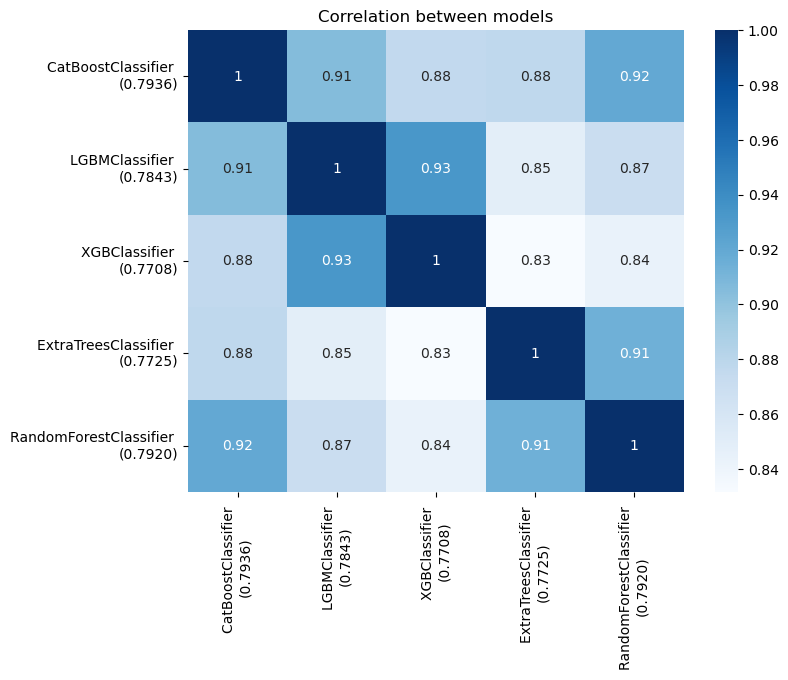

In [48]:
pred_results = []
for clf in clfs :
    pred = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    name = type(clf).__name__
    score = roc_auc_score(y_test, pred)
    pred_results.append(pd.Series(pred, name=f'{name} \n({score:.4f})'))
    print("{:30s} {}".format(name, score))

ensemble_results = pd.concat(pred_results, axis=1)
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(),annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

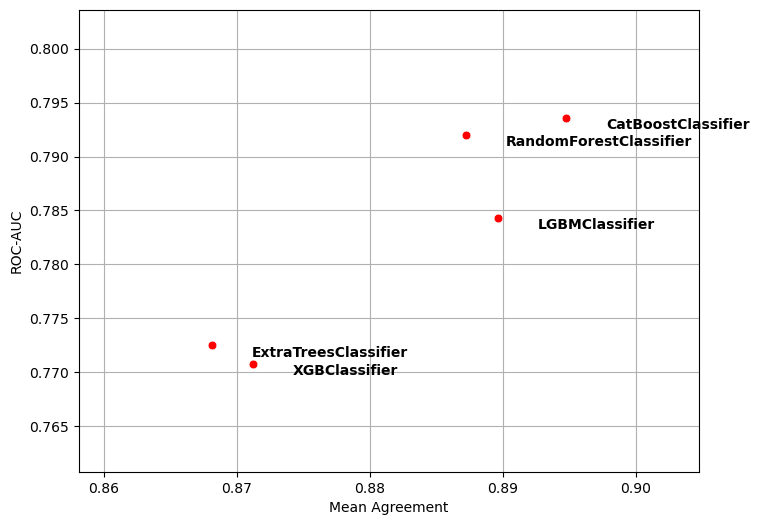

In [49]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index.str[:-10]
aucs = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]-0.001, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

### <font color = 'navy'> Predict

In [21]:
# ensemble_pred = cat_pred*0.4 + rf_pred*0.6

In [112]:
ensemble_pred = cat_pred*0.65 + rf_pred*0.35

In [113]:
score = roc_auc_score(y_test, ensemble_pred)

In [114]:
score

0.7962962962962963